In [1]:
import hoomd
import gsd.hoomd
import numpy as np
import sys 
import matplotlib.pyplot as plt

sys.path.append("..")
from src import smd
from src.utilities import ChIMES

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']
plt.rcParams['mathtext.it'] = 'Helvetica:italic'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']=(2, 2)
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['figure.titlesize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3.0


In [2]:
def LJ(r, epsilon, sigma):
    quotient = sigma / r 
    quotient_6 = quotient * quotient * quotient * quotient * quotient * quotient
    
    return 4 * epsilon * (quotient_6 * quotient_6 - quotient_6)

In [3]:
TIME_CONVERSION = 0.01  # From 1 fs to 100fs (derived time unit)
VELOCITY_CONVERSION = 1 / 0.01  # From 1 A/fs to 0.01 A/fs (=1 nm/ps)

In [4]:
# particle information
dt = 1   # fs
mass = 56.0
box_length = 100.0
init_p1 = np.array([0., 2**(1/6)/2, 0.])
init_p2 = np.array([0., -2**(1/6)/2, 0.])
init_p3 = np.array([3., 0., 0.])

spring_constant_pull = 100
spring_constant_fix = 200

ang_vel_conversion = 100  # convert ang vel to radian / timestep 

# thermo parameters
T = 10             # K
kb = 0.00831446262  # kJ/mol/K
kT = kb*T
tau = 10.0 * dt
tau *= TIME_CONVERSION

epsilon = 1.0
sigma = 1.0
r_cut = 6.0

# sim params
traj_fn = "traj_3b.gsd"
dump_period = 1000
total_steps = 190_000
eq_steps = 50_000
seed = 1000
segment = 10_000
pull_velocity = -1.0E-5
pull_direction = np.array([1.0, 0.0, 0.0])
dt *= TIME_CONVERSION
pull_velocity *= VELOCITY_CONVERSION


In [5]:
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = 3
snapshot.particles.position = np.vstack((init_p1, init_p2, init_p3))
snapshot.particles.types = ['A'] 
snapshot.particles.typeid = [0] * 3 
snapshot.configuration.box = [box_length, box_length, box_length, 0.0, 0.0, 0.0]
snapshot.particles.mass = [mass] * 3
snapshot.configuration.step = 0

In [6]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device, seed=seed)
sim.timestep = 0
sim.create_state_from_snapshot(snapshot)


In [7]:
forces = []
nl = hoomd.md.nlist.Cell(buffer=0.5, default_r_cut=r_cut)  

lj = hoomd.md.pair.LJ(nlist=nl, default_r_cut=r_cut)
lj.params[('A', 'A')] = dict(epsilon=epsilon, sigma=sigma)
lj.r_cut[('A', 'A')] = r_cut

forces.append(lj)

In [8]:
smd_force = smd.SMD_constV_threebody(
    sim=sim,
    group1_idx=[0],
    group2_idx=[1],
    group3_idx=[2],
    dt=dt,
    pulling_velocity=pull_velocity,
    spring_constant_fix=spring_constant_fix,
    spring_constant_pull=spring_constant_pull,
    r_c=np.array([0., 0., 0.]),
    r_fix=np.stack((init_p1, init_p2)),
    pulling_direction=pull_direction
)
forces.append(smd_force)

In [9]:
ensemble = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.MTTK(kT=kT, tau=tau)
)

In [10]:

integrator = hoomd.md.Integrator(
    dt=dt,
    methods=[ensemble],
    forces=forces,
    integrate_rotational_dof=False
)
sim.operations += integrator

In [11]:
logger = hoomd.logging.Logger()
logger.add(obj=lj, quantities=["energy"])

gsd_writer = hoomd.write.GSD(
    filename=traj_fn,
    trigger=hoomd.trigger.Periodic(dump_period),
    dynamic=["property"],
    mode='wb',
    logger=logger
)
sim.operations += gsd_writer

In [12]:
sim.operations += smd_force.get_writer("smd_3b.txt", dump_period)

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
sim.operations += hoomd.md.update.ZeroMomentum(hoomd.trigger.On(0))

In [13]:
sim.run(0)
sim.operations.writers[-1].write()

while sim.timestep < total_steps:
    sim.run(segment)
    for writer in sim.operations.writers:
        if hasattr(writer, 'flush'):
            writer.flush()

velocity = np.copy(smd_force._velocity)
smd_force._velocity = 0.
sim.run(eq_steps)
for writer in sim.operations.writers:
    if hasattr(writer, 'flush'):
        writer.flush()
    
smd_force._velocity = -velocity
while sim.timestep < (total_steps*2 + eq_steps):
    sim.run(segment)
    for writer in sim.operations.writers:
        if hasattr(writer, 'flush'):
            writer.flush()

### Process the 3b smd data into three-body PMFs. Notice that it contains the two-body contribution!

In [14]:
fn = np.genfromtxt("smd_3b.txt", skip_header=1)
timestep = fn[:, 0]
work = fn[:, -1] 
distance_3c = fn[:, -3]

num_frames = int(total_steps / dump_period) + 1
work_fw = work[:num_frames]
work_rv = work[-num_frames:][::-1]
distance_3c = distance_3c[:num_frames]

distance_13 = np.sqrt(distance_3c**2.0 + (2**(1/6)/2)**2.0)

three_pmf = (work_fw - work_rv) / 2
three_pmf -= three_pmf[0]

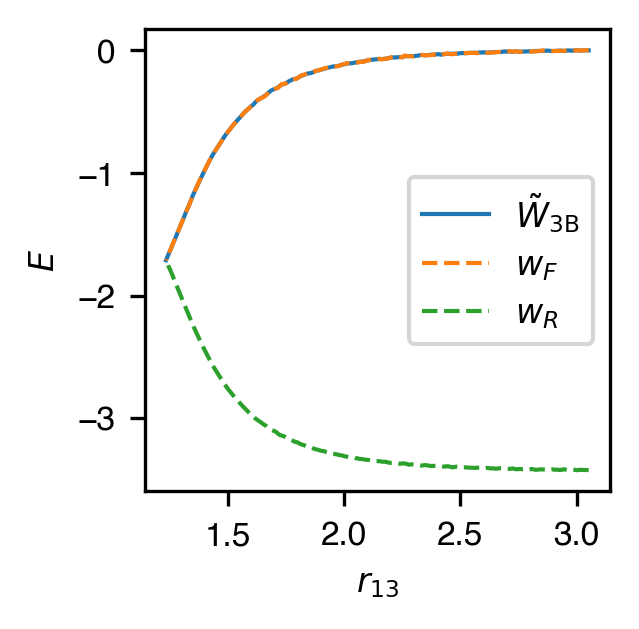

In [15]:
plt.plot(distance_13, three_pmf, label=r"$\tilde{W}_\mathrm{3B}$")
plt.plot(distance_13, work_fw, "--", label=r"$w_F$")
plt.plot(distance_13, work_rv, "--", label=r"$w_R$")
plt.xlabel(r"$r_{13}$")
plt.ylabel(r"$E$")
plt.legend()

### Load two-body ChIMSE coefficient.

In [16]:
chimes = ChIMES()
c_2b = np.load("chimes_2b.npz")["c_2b"]

### Calculate two-body PMF using ChIMES, contributed from Particle 1,3 and 2,3

In [17]:
O2b = 18
chimes_rout = 3.0
tersoff_fo = 0.75
chimes_rin = 0.95
morse_lambda = 2 ** (1/6)

x, xin, xout = chimes.morse_trans(distance_13, chimes_rin, chimes_rout, morse_lambda)
s = chimes.rescale_into_s(x, xin, xout)

smooth = chimes.tersoff_smooth(distance_13, tersoff_fo, chimes_rout)

A = chimes.make_Amatrix(s, O2b, smooth, 0)
pmf_2b_chimes = A @ c_2b

### Remove two-body contribution to obtain pure three-body PMF.

In [18]:
pmf_3b_correction = three_pmf - 2 * pmf_2b_chimes

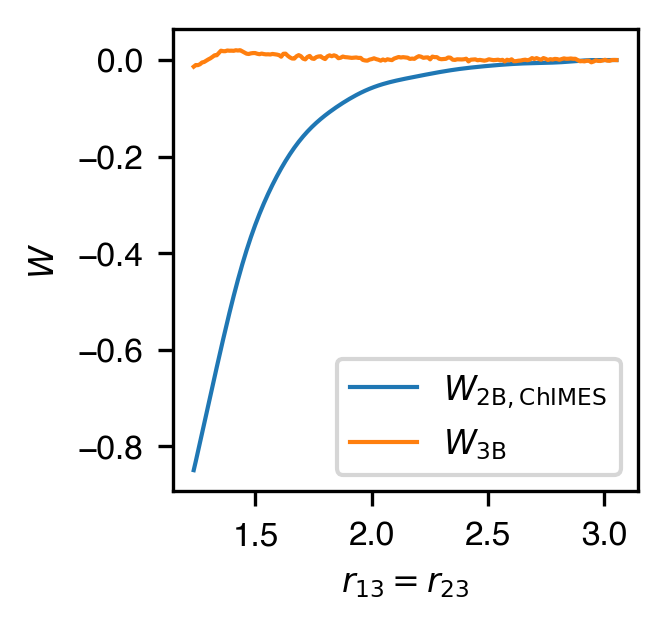

In [21]:
plt.plot(distance_13, pmf_2b_chimes, label=r"$W_\mathrm{2B, ChIMES}$")
plt.plot(distance_13, pmf_3b_correction, label=r"$W_\mathrm{3B}$")
plt.xlabel(r"$r_{13}=r_{23}$")
plt.ylabel(r"$W$")
plt.legend()